This is an atempt to implement the Deformable Convolution Layer as described in the 2017 paper by Jifeng Dai et al. 

Inspiration was taken from the implementation of Juliang Wang (https://github.com/Junliangwangdhu/WaferMap) for mixed-type wafer defect classification.

In [1]:
import numpy as np
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
%matplotlib inline

filepath = 'drive/MyDrive/Colab Notebooks/Wafer_defect/Trained_Model_wGPU_20E_weights/'

tensorflow version: 2.7.0


Loading and Visualizing Dataset

In [2]:
dataset = np.load('drive/MyDrive/Colab Notebooks/Wafer_defect/MixedWM38.npz')
dataset_x, dataset_y = dataset['arr_0'], dataset['arr_1']
m, n_H, n_W = dataset_x.shape

print(f"dataset_x shape: {dataset_x.shape}")
print(f"dataset_y shape: {dataset_y.shape}")

dataset_x shape: (38015, 52, 52)
dataset_y shape: (38015, 8)


Text(0.5, 1.0, 'Fault: [0 1 1 0 1 0 0 0]')

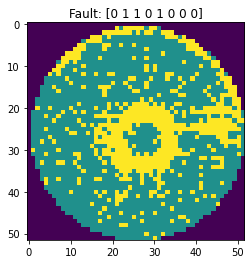

In [3]:
# plot example
random_example = np.random.randint(0, dataset_x.shape[0])
plt.imshow(dataset_x[random_example,:,:])
plt.title(f'Fault: {dataset_y[random_example]}')

Split Dataset into Train/Dev/Test sets

In [48]:
# reshape the input to have shape of image with 1 channel
dataset_x_cnn = np.expand_dims(dataset_x, axis=-1)

# split the dataset into train (80%), dev(10%) and test(10%) sets
shuffled_idx = np.asarray(list(range(dataset_x_cnn.shape[0])))
np.random.shuffle(shuffled_idx)

shuffled_x = dataset_x_cnn[shuffled_idx, :, :, :]
shuffled_y = dataset_y[shuffled_idx, :]

train_cut = int(shuffled_x.shape[0]*.80)

dev_cut = int(shuffled_x.shape[0]*.90)

train_x = shuffled_x[:train_cut, :, :, :]
train_y = shuffled_y[:train_cut, :]

dev_x = shuffled_x[train_cut:dev_cut, :, :, :]
dev_y = shuffled_y[train_cut:dev_cut, :]

test_x = shuffled_x[dev_cut:, :, :]
test_y = shuffled_y[dev_cut:, :]

In [5]:
print(f"train set shape: {train_x.shape}")
print(f"dev set shape: {dev_x.shape}")
print(f"test set shape: {test_x.shape}")

print("\n")
print(f"size of input shape to the model:\nn_H: {n_H}\nn_W: {n_W}")

train set shape: (30412, 52, 52, 1)
dev set shape: (3801, 52, 52, 1)
test set shape: (3802, 52, 52, 1)


size of input shape to the model:
n_H: 52
n_W: 52


Defining a new tensorflow layer class "DefConvLayer"

Notes:
1.   the offset metrices are learned through a standard convolutional layer, with 2xN number of filters (=channels) corresponding to N 2D offsets *for each input pixel*.
2.   There is a set of 2D offsets for each spatial location of the input feature map. from the 2017 paper: "The output offset fields have the same spatial resolution with the input feature map."
     Meaning, it won't be enough to compute a static "offset" input "x_offset" and then applyting regular convolution, but each output pixel need to compute the kernel weightings on a different locations of input pixels/values. for that, I'll use a straight forward implementation of the deformable convolutional block.
3.   Since the offsets are fractional values, the values of the input at the offset location will be "estimated" using [Bi-linear Interpolation](https://en.wikipedia.org/wiki/Bilinear_interpolation). Using the notation of the figure below, first I'll compute the linear interpolation of the top and bottom coordinates R1 and R2, then use these values to compute a second linear interpolation for the coordinate P.


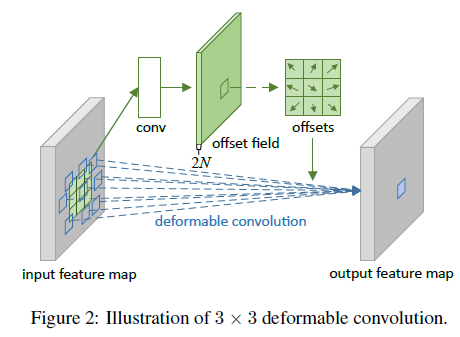

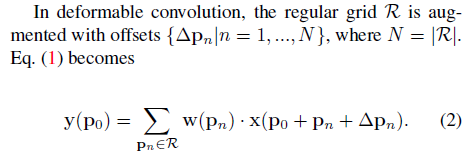


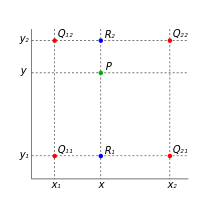



In [6]:
def DefConv_full(input, filters, kernel_size=3, strides=1, name=None):
    """
    Using DefConv_reduced to implement full DC layer.
    """
    offsets = layers.Conv2D(name=f'Conv2D_offsets_{name}',
                            filters=2 * kernel_size ** 2,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same',
                            kernel_initializer='random_normal'
                            )(input)
    X = DefConvLayer_red(name=f'defconv_{name}',
                         filters=filters,
                         kernel_size=kernel_size,
                         strides=strides
                         )(input, offsets)
    return X



class DefConvLayer_red(Layer):

    def __init__(self, filters, kernel_size=3, strides=1, **kwargs):
        assert type(kernel_size) == int, "expect kernel_size to be of type 'int'"
        assert type(strides) == int, "expect strides to be of type int"
        self.N = kernel_size ** 2
        self.filters = filters
        self.strides = strides

        super(DefConvLayer_red, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="Wdc",
                                 shape=(input_shape[-1], self.N, self.filters),
                                 # Wdc is of shape [n_C=input_channels, lxl=N, filters=output_channels]
                                 initializer='RandomNormal',
                                 dtype='float32',
                                 trainable=True)

    def call(self, input, offsets):
        # input of shape: (m=batch_size, n_H, n_W, n_C)
        # offsets of shape: (m, n_H, n_W, 2*N)
        # m, n_H, n_W, n_C = input.shape
        # offsets = super(DefConvLayer, self).call(input) # Conv2D to learn offsets (m, n_H, n_W, 2*N)

        input_offsets = self.BLIN(input, offsets)  # (m, n_H, n_W, n_C, N)
        # BLIN returns N interpolated values of input at the offsets, for each spatial pixel
        # replicate the offset input to each of the output channels
        input_offsets = tf.expand_dims(input_offsets, axis=-1)
        input_offsets = tf.tile(input_offsets, [1, 1, 1, 1, 1, self.filters])  # (m, n_H, n_W, n_C, N, filters)

        new_shape = (1, 1, 1,) + self.W.shape
        W = tf.reshape(self.W, shape=new_shape)  # (1, 1, 1, n_C, N, filters) to be broadcastable to input_offsets

        output = tf.multiply(input_offsets, W)  # (m, n_H, n_W, n_C, N, filters)
        output = tf.math.reduce_sum(output, axis=-2)  # (m, n_H, n_W, n_C, filters) reduce along each channel kernel
        output = tf.math.reduce_sum(output, axis=-2)  # (m, n_H, n_W, filters) reduce along input channels
        return output

    @tf.function
    def BLIN(self, input, offsets_in):  # Bi-Linear Interpolation of input feature map values at offset locations
        """
        'input' shape: (m, n_Hi, n_Wi, n_C)
        'offsets_in' shape: (m, n_Ho, n_Wo, 2*N)
        'offsets_in' is the output of the Conv2D layer step aimed at learning the offsets,
                     possibly smaller spatial size than input's, if strides>1
        """
        offsets = offsets_in
        m    = tf.shape(input)[0]
        n_Hi = tf.shape(input)[1]
        n_Wi = tf.shape(input)[2]
        n_C  = tf.shape(input)[3]

        n_Ho = tf.shape(offsets)[1] # also the output spatial shape
        n_Wo = tf.shape(offsets)[2]
        N    = tf.shape(offsets)[3] // 2

        # expand the input into (m, n_Hi, n_Wi, n_C, N). this will also be the output shape of this function
        input_offsets = tf.expand_dims(input, axis=-1) # (m, n_Hi, n_Wi, n_C, N, 1)
        # replicate N times, to be compatible with the kernel operation later
        input_offsets = tf.tile(input_offsets, [1, 1, 1, 1, N])  # (m, n_Hi, n_Wi, n_C, N)

        # the offset metrices will be replicated n_C times: same (spatial) offsets for each of the input *channels*.
        offsets = tf.reshape(offsets, (m, n_Ho, n_Wo, 1, N, 2))  # (m, n_Ho, n_Wo, 1, N, 2) add a "channel" axis
        offsets = tf.tile(offsets, [1, 1, 1, n_C, 1, 1])  # (m, n_Ho, n_Wo, n_C, N, 2) replicate for each of the input channels

        # construct a full index grid to be applied onto "input_offsets" of size (m, n_H, n_W, n_C, N)
        (grid_m, grid_i, grid_j, grid_c, grid_N) = tf.meshgrid(tf.range(m), tf.range(n_Hi),
                                                               tf.range(n_Wi), tf.range(n_C), tf.range(N),
                                                               indexing='ij')  # (m, n_Hi, n_Wi, n_C, N) a list of 5 metrices with index-like values

        # adjust indices to 'strides' down-sample, and
        # unroll indices to fit into tf.gather_nd later. (unroll offsets also)
        ur_grid_m = tf.reshape(grid_m[:, ::self.strides, ::self.strides, :, :], [-1])  # (m*n_Ho*n_Wo*n_C*N, 1); integers
        ur_grid_i = tf.reshape(grid_i[:, ::self.strides, ::self.strides, :, :], [-1])
        ur_grid_j = tf.reshape(grid_j[:, ::self.strides, ::self.strides, :, :], [-1])
        ur_grid_c = tf.reshape(grid_c[:, ::self.strides, ::self.strides, :, :], [-1])
        ur_grid_N = tf.reshape(grid_N[:, ::self.strides, ::self.strides, :, :], [-1])
        ur_offsets = tf.reshape(offsets, (-1, 2))  # (m*n_Ho*n_Wo*n_C*N, 2) both i, j

        # spatial indices will be adjusted using 'offsets'
        coords_i = tf.cast(ur_grid_i, dtype='float32') + ur_offsets[..., 0]
        coords_j = tf.cast(ur_grid_j, dtype='float32') + ur_offsets[..., 1]

        # Need to think further on how to handle edges,
        # perhaps assume outside of index values can be zeros instead of hard-clipping.
        coords_i = tf.clip_by_value(coords_i, 0, tf.cast(n_Hi, dtype='float32')-1)
        coords_j = tf.clip_by_value(coords_j, 0, tf.cast(n_Wi, dtype='float32')-1)
        coords_2d = tf.stack([coords_i, coords_j], axis=-1)  # (m*n_Ho*n_Wo*n_C*N, 2); float32

        # generate top and bottom, left and right, nearest "real" indices
        # assuming coords represents (p,q) values where i<=p<=i+1, and j<=q<=j+1:
        # shape: (m*n_Ho*n_Wo*n_C*N, 2)
        # note the coordinates themselves (values in coords) are [i,j] within [0:n_Hi-1, 0:n_Wi] range
        coords_lt = tf.cast(tf.math.floor(coords_2d), dtype='int32')  # nearest (i,j)
        coords_rb = tf.cast(tf.math.ceil(coords_2d), dtype='int32')  # nearest (i+1, j+1)

        coords_lb = tf.stack((coords_rb[..., 0], coords_lt[..., 1]), axis=-1)  # nearest (i+1, j)
        coords_rt = tf.stack((coords_lt[..., 0], coords_rb[..., 1]), axis=-1)  # nearest (i, j+1)

        # use the replicated input tensor "input_offsets" which holds the input values, to get these values at the specific locations:
        # these type of Tensors doesn't allow for conversion into numpy-like arrays. to use tf.gather_nd, need to unroll indices
        # unroll all grid tensors to be used with tf.gather_nd()

        indices_lt = tf.stack([ur_grid_m, coords_lt[..., 0], coords_lt[..., 1], ur_grid_c, ur_grid_N], axis=-1)
        indices_rb = tf.stack([ur_grid_m, coords_rb[..., 0], coords_rb[..., 1], ur_grid_c, ur_grid_N], axis=-1)
        indices_lb = tf.stack([ur_grid_m, coords_lb[..., 0], coords_lb[..., 1], ur_grid_c, ur_grid_N], axis=-1)
        indices_rt = tf.stack([ur_grid_m, coords_rt[..., 0], coords_rt[..., 1], ur_grid_c, ur_grid_N], axis=-1)

        vals_lt = tf.gather_nd(input_offsets, indices_lt)
        vals_rb = tf.gather_nd(input_offsets, indices_rb)
        vals_lb = tf.gather_nd(input_offsets, indices_lb)
        vals_rt = tf.gather_nd(input_offsets, indices_rt)

        # calculate the offset from the left-top (i,j) position
        ur_coords_offset_lt = coords_2d - tf.cast(coords_lt, dtype='float32')  # (m*n_Ho*n_Wo*n_C*N, 2)

        # first linear interpolation (m*n_H*n_W*n_C*N)
        vals_t = vals_lt + (vals_rt - vals_lt) * ur_coords_offset_lt[..., 1]  # along the j axis (n_Wi), top
        vals_b = vals_lb + (vals_rb - vals_lb) * ur_coords_offset_lt[..., 1]  # along the j axis (n_Wi), bottom

        # second linear interpolation
        input_offsets = vals_t + (vals_b - vals_t) * ur_coords_offset_lt[..., 0]  # along the i axis (n_Hi)

        # reshape back to output shape
        input_offsets = tf.reshape(input_offsets, (m, n_Ho, n_Wo, n_C, N))

        return input_offsets

Constructing the DC Model

In [7]:
def DCNet_model_2020(input_shape, classes=8, trainable=True):
    """
    Deformable Convolution model with 4 Blocks of DC layers (paper used 5), 
    followed by Global Avg Pooling (instead of a FC layer) and 1 FC output layer with sigmoid activation.
    :param input_shape: (52, 52, 1)
    :param classes: 8
    :return: keras model object
    """

    X_input = layers.Input(input_shape)

    # Module 1
    X = layers.Conv2D(name='conv2d_module_1', 
                      filters=32, 
                      kernel_size=5, 
                      strides=1, 
                      padding='valid', 
                      kernel_initializer='random_normal'
                      )(X_input)
    X = layers.BatchNormalization(axis=3, name='bn_1')(X)
    X = layers.Activation('relu')(X)

    # Module 2
    name='module_2'
    X = layers.Conv2D(name=f'conv2d_{name}', 
                      filters=64, 
                      kernel_size=3, 
                      strides=1, 
                      padding='valid', 
                      kernel_initializer='random_normal'
                      )(X)
    X = DefConv_full(X, filters=64, kernel_size=3, strides=1, name=name)
    X = layers.BatchNormalization(axis=3, name='bn_2')(X)
    X = layers.Activation('relu')(X)

    # Module 3
    name='module_3'
    X = layers.Conv2D(name=f'conv2d_{name}', 
                      filters=128, 
                      kernel_size=3, 
                      strides=1, 
                      padding='valid', 
                      kernel_initializer='random_normal'
                      )(X)
    X = DefConv_full(X, filters=128, kernel_size=3, strides=1, name=name)
    X = layers.BatchNormalization(axis=3, name='bn_3')(X)
    X = layers.Activation('relu')(X)

    # Module 4
    name='module_4'
    X = layers.Conv2D(name=f'conv2d_{name}', 
                      filters=128, 
                      kernel_size=3, 
                      strides=1, 
                      padding='valid', 
                      kernel_initializer='random_normal'
                      )(X)
    X = DefConv_full(X, filters=128, kernel_size=3, strides=1, name=name)
    X = layers.BatchNormalization(axis=3, name='bn_4')(X)
    X = layers.Activation('relu')(X)

    # Module 5
    # X = layers.Flatten()(X)
    # X = layers.Dense(units=64, activation='relu')(X)
    # instead of the dense layer (many millions of parameters), I'll use Global Avg Pooling
    X = layers.GlobalAvgPool2D(name='GlbAvgPool')(X)
    X = layers.Dense(units=classes, activation='sigmoid')(X)

    model = tf.keras.Model(inputs=X_input, outputs=X)
    return model

In [8]:
def DCNN_model_2017(input_shape, classes=8, trainable=True):
    """
    Deformable Convolution model with 4 Blocks of DC layers (paper used 5), 
    followed by Global Avg Pooling (instead of a FC layer) and 1 FC output layer with sigmoid activation.
    :param input_shape: (52, 52, 1)
    :param classes: 8
    :return: keras model object
    """

    X_input = layers.Input(input_shape)

    

    # Block 1
    kernel_size_1 = 3
    strides_1 = 2
    offsets_1 = layers.Conv2D(name='Conv2D_offsets_1',
                              filters=2 * kernel_size_1**2,
                              kernel_size=kernel_size_1,
                              strides=strides_1,
                              padding='same',
                              kernel_initializer='random_normal'
                              )(X_input)
    X = DefConvLayer_red(name='defconv_1',
                         filters=32,
                         kernel_size=kernel_size_1,
                         strides=strides_1
                         )(X_input, offsets_1)
    X = layers.BatchNormalization(axis=3, name='bn_1')(X)
    X = layers.Activation('relu')(X)
    
    # Block 2
    kernel_size_2 = 3
    strides_2 = 1
    offsets_2 = layers.Conv2D(name='Conv2D_offsets_2',
                              filters=2 * kernel_size_2**2,
                              kernel_size=kernel_size_2,
                              strides=strides_2,
                              padding='same',
                              kernel_initializer='random_normal')(X)
    X = DefConvLayer_red(filters=64,
                         kernel_size=kernel_size_2,
                         strides=strides_2,
                         name='defconv_2')(X, offsets_2)
    X = layers.BatchNormalization(axis=3, name='bn_2')(X)
    X = layers.Activation('relu')(X)
    # X = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), name='MaxPool_2')(X)

    # Block 3
    kernel_size_3 = 3
    strides_3 = 2
    offsets_3 = layers.Conv2D(name='Conv2D_offsets_3',
                              filters=2 * kernel_size_3**2,
                              kernel_size=kernel_size_3,
                              strides=strides_3,
                              padding='same',
                              kernel_initializer='random_normal')(X)
    X = DefConvLayer_red(filters=128,
                         kernel_size=kernel_size_3,
                         strides=strides_3,
                         name='defconv_3')(X, offsets_3)
    X = layers.BatchNormalization(axis=3, name='bn_3')(X)
    X = layers.Activation('relu')(X)
    
    # Block 4
    kernel_size_4 = 3
    strides_4 = 2
    offsets_4 = layers.Conv2D(name='Conv2D_offsets_4',
                              filters=2 * kernel_size_4**2,
                              kernel_size=kernel_size_4,
                              strides=strides_4,
                              padding='same',
                              kernel_initializer='random_normal')(X)
    X = DefConvLayer_red(filters=128,
                         kernel_size=kernel_size_4,
                         strides=strides_4,
                         name='defconv_4')(X, offsets_4)
    X = layers.BatchNormalization(axis=3, name='bn_4')(X)
    X = layers.Activation('relu')(X)

    # Pooling Layer (instead of FC1) with number of units as the number of channels (256 above)
    X = layers.GlobalAvgPool2D(name='GlbAvgPool')(X)

    # FC output Layer
    X = layers.Dense(units=classes, activation='sigmoid', name='FC', trainable=trainable)(X)

    model = tf.keras.Model(inputs=X_input, outputs=X)
    return model

In [9]:
model = DCNN_model_2017(input_shape=(n_H, n_W, 1), classes=8, trainable=True)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 52, 52, 1)]  0           []                               
                                                                                                  
 Conv2D_offsets_1 (Conv2D)      (None, 26, 26, 18)   180         ['input_1[0][0]']                
                                                                                                  
 defconv_1 (DefConvLayer_red)   (None, 26, 26, 32)   288         ['input_1[0][0]',                
                                                                  'Conv2D_offsets_1[0][0]']       
                                                                                                  
 bn_1 (BatchNormalization)      (None, 26, 26, 32)   128         ['defconv_1[0][0]']          

Define Custom Accuracy Measure (exact matches)

In [10]:
class MultiLabel_Accuracy(tf.keras.metrics.Metric):
    def __init__(self, name='multilabel_accuracy', threshold=0.5):
        super(MultiLabel_Accuracy, self).__init__(name=name)
        self.accuracy = self.add_weight(name='accuracy', initializer='zeros')
        self.threshold = threshold
        self.count = self.add_weight(name='count', initializer='zeros')

    def result(self):
        return tf.math.divide(self.accuracy, self.count)

    def reset_state(self):
        self.accuracy.assign(0)
        self.count.assign(0)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], dtype='float32'))
        pred = tf.where(y_pred > self.threshold, 1, 0)

        tmp = tf.cast(y_true == pred, dtype='float32')
        tmp = tf.reduce_sum(tmp, axis=-1)
        # hard-coded 8 labels total
        tmp = tf.where(tmp==8, 1, 0)
        tmp = tf.reduce_sum(tmp)

        self.accuracy.assign_add(tf.cast(tmp, dtype='float32'))

In [11]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=.9) # default lr=0.001
metric = MultiLabel_Accuracy(name='multilabel_accuracy')
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[metric])

In [12]:
# metric = MultiLabel_Accuracy(name='multilabel_accuracy')
# checkpoint_filepath = filepath+'checkpoint/'
# custom_obj = {}
# custom_obj['multilabel_accuracy'] = MultiLabel_Accuracy
# custom_obj['DefConvLayer_red'] = DefConvLayer_red
# model = tf.keras.models.load_model(checkpoint_filepath, custom_objects=custom_obj)

In [13]:
checkpoint_filepath = filepath+'checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True,
                                                               monitor='val_multilabel_accuracy',
                                                               mode='max',
                                                               save_best_only=True)
model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


model_history = model.fit(train_x, train_y, 
                          epochs=20,
                          validation_data=(dev_x, dev_y),
                          batch_size=32,
                          callbacks=[model_checkpoint_callback]
                          )

Epoch 1/20
951/951 [==============================] - 2144s 2s/step - loss: 0.3418 - multilabel_accuracy: 0.2839 - val_loss: 0.2677 - val_multilabel_accuracy: 0.3162
Epoch 2/20
951/951 [==============================] - 2126s 2s/step - loss: 0.1727 - multilabel_accuracy: 0.5560 - val_loss: 0.1879 - val_multilabel_accuracy: 0.4783
Epoch 3/20
951/951 [==============================] - 2131s 2s/step - loss: 0.1275 - multilabel_accuracy: 0.6061 - val_loss: 0.2918 - val_multilabel_accuracy: 0.4370
Epoch 4/20
951/951 [==============================] - 2133s 2s/step - loss: 0.1050 - multilabel_accuracy: 0.6907 - val_loss: 0.1046 - val_multilabel_accuracy: 0.6875
Epoch 5/20
951/951 [==============================] - 2134s 2s/step - loss: 0.0769 - multilabel_accuracy: 0.8492 - val_loss: 0.0680 - val_multilabel_accuracy: 0.8758
Epoch 6/20
951/951 [==============================] - 2138s 2s/step - loss: 0.0527 - multilabel_accuracy: 0.9049 - val_loss: 0.0755 - val_multilabel_accuracy: 0.8671
Epoc

In [14]:
model.save(filepath+'model_save/')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/Wafer_defect/Trained_Model_wGPU_20E_weights/model_save/assets


In [15]:
train_loss = model_history.history['loss']
train_acc = model_history.history['multilabel_accuracy']

val_loss = model_history.history['val_loss']
val_acc = model_history.history['val_multilabel_accuracy']

Text(0.5, 1.0, 'Validation Accuracy')

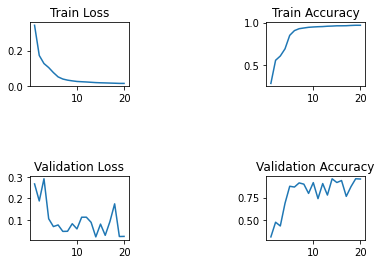

In [16]:
plt.subplot(3,3,1)
plt.plot((np.arange(1, len(train_loss)+1)), train_loss)
plt.title('Train Loss')

plt.subplot(3,3,3)
plt.plot((np.arange(1,len(train_acc)+1)), train_acc)
plt.title('Train Accuracy')

plt.subplot(3,3,7)
plt.plot((np.arange(1, len(val_loss)+1)), val_loss)
plt.title('Validation Loss')

plt.subplot(3,3,9)
plt.plot((np.arange(1,len(val_acc)+1)), val_acc)
plt.title('Validation Accuracy')


Load the trained Model

Some prediction examples

In [17]:
random_examples = np.random.randint(0, dev_x.shape[0], size=9)

predictions = model(dev_x[random_examples, :,:, 0])
predictions = np.where(predictions>0.5, 1, 0)

metric.reset_state()
metric.update_state(dev_y[random_examples], predictions)
print(f"Accuracy of random samples: {metric.result().numpy()}")

Accuracy of random samples: 1.0


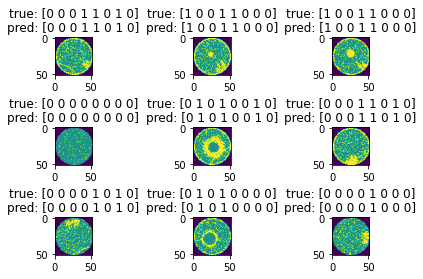

In [18]:
for i in range(3):
    plt.subplot(5,5, 10*i+1)
    plt.imshow(dev_x[random_examples[i],:,:,0])
    plt.title(f'true: {dev_y[random_examples[i]]}\npred: {predictions[i]}')

    plt.subplot(5,5, 10*i+3)
    plt.imshow(dev_x[random_examples[i+3],:,:,0])
    plt.title(f'true: {dev_y[random_examples[i+3]]}\npred: {predictions[i+3]}')

    plt.subplot(5,5, 10*i+5)
    plt.imshow(dev_x[random_examples[i+6],:,:,0])
    plt.title(f'true: {dev_y[random_examples[i+6]]}\npred: {predictions[i+6]}')

In [19]:
predictions = model.predict(test_x, batch_size=64, verbose=1)
predictions = np.where(predictions>.5, 1, 0)

metric.reset_state()
metric.update_state(test_y, predictions)
print(f"Test set accuracy: {metric.result().numpy()}")

60/60 [==============================] - 231s 4s/step
Test set accuracy: 0.9573908448219299


In [20]:
from sklearn import metrics
f1_score = metrics.f1_score(test_y, predictions, average=None)
print(f"confusion metrices:\n{metrics.multilabel_confusion_matrix(test_y, predictions)}")
print(f"f-score per class:\n{f1_score}")
print(f"average f1-score: {np.average(f1_score)}")

confusion metrices:
[[[2500    0]
  [   0 1302]]

 [[2563    0]
  [   1 1238]]

 [[2498    0]
  [  43 1261]]

 [[2578   26]
  [   0 1198]]

 [[2006    2]
  [  73 1721]]

 [[3788    3]
  [   0   11]]

 [[1888    7]
  [  32 1875]]

 [[3711    0]
  [   0   91]]]
f-score per class:
[1.         0.99959629 0.98323587 0.98926507 0.97867501 0.88
 0.98970705 1.        ]
average f1-score: 0.977559909661057


Evaluating Accuracy for Multi-Label Dataset

In [21]:
# defining Pattern Type Labels
pdict = {}

# No Fault
pdict['C1'] = [0, 0, 0, 0, 0, 0, 0, 0] # Normal

# Single Defect
pdict['C2'] = [1, 0, 0, 0, 0, 0, 0, 0] # Center
pdict['C3'] = [0, 1, 0, 0, 0, 0, 0, 0] # Donut
pdict['C4'] = [0, 0, 1, 0, 0, 0, 0, 0] # Edge_Local
pdict['C5'] = [0, 0, 0, 1, 0, 0, 0, 0] # Edge_Ring
pdict['C6'] = [0, 0, 0, 0, 1, 0, 0, 0] # Local
pdict['C7'] = [0, 0, 0, 0, 0, 1, 0, 0] # Near_Full
pdict['C8'] = [0, 0, 0, 0, 0, 0, 1, 0] # Scratch
pdict['C9'] = [0, 0, 0, 0, 0, 0, 0, 1] # Random

# 2 Mixed-type Defect
pdict['C10'] = [1, 0, 1, 0, 0, 0, 0, 0]
pdict['C11'] = [1, 0, 0, 1, 0, 0, 0, 0]
pdict['C12'] = [1, 0, 0, 0, 1, 0, 0, 0]
pdict['C13'] = [1, 0, 0, 0, 0, 0, 1, 0]
pdict['C14'] = [0, 1, 1, 0, 0, 0, 0, 0]
pdict['C15'] = [0, 1, 0, 1, 0, 0, 0, 0]
pdict['C16'] = [0, 1, 0, 0, 1, 0, 0, 0]
pdict['C17'] = [0, 1, 0, 0, 0, 0, 1, 0]
pdict['C18'] = [0, 0, 1, 0, 1, 0, 0, 0]
pdict['C19'] = [0, 0, 1, 0, 0, 0, 1, 0]
pdict['C20'] = [0, 0, 0, 1, 1, 0, 0, 0]
pdict['C21'] = [0, 0, 0, 1, 0, 0, 1, 0]
pdict['C22'] = [0, 0, 0, 0, 1, 0, 1, 0]

# 3 Mixed-type Defect
pdict['C23'] = [1, 0, 1, 0, 1, 0, 0, 0]
pdict['C24'] = [1, 0, 1, 0, 0, 0, 1, 0]
pdict['C25'] = [1, 0, 0, 1, 1, 0, 0, 0]
pdict['C26'] = [1, 0, 0, 1, 0, 0, 1, 0]
pdict['C27'] = [1, 0, 0, 0, 1, 0, 1, 0]
pdict['C28'] = [0, 1, 1, 0, 1, 0, 0, 0]
pdict['C29'] = [0, 1, 1, 0, 0, 0, 1, 0]
pdict['C30'] = [0, 1, 0, 1, 1, 0, 0, 0]
pdict['C31'] = [0, 1, 0, 1, 0, 0, 1, 0]
pdict['C32'] = [0, 1, 0, 0, 1, 0, 1, 0]
pdict['C33'] = [0, 0, 1, 0, 1, 0, 1, 0]
pdict['C34'] = [0, 0, 0, 1, 1, 0, 1, 0]

# 4 Mixed-type Defect
pdict['C35'] = [1, 0, 1, 0, 1, 0, 1, 0]
pdict['C36'] = [1, 0, 0, 1, 1, 0, 1, 0]
pdict['C37'] = [0, 1, 1, 0, 1, 0, 1, 0]
pdict['C38'] = [0, 1, 0, 1, 1, 0, 1, 0]

In [39]:
def type_eval(test_x, test_y, pdict):
  """
  test_x, test_y: the dataset on which to perform the evaluation
  pdict: a dictionary with the pattern labels
  """

  acc_list = []

  for i in range(1, 39):
    print(f"Evaluating Pattern C{i}:")
    idx = np.all(test_y == [pdict['C'+str(i)]], axis=1)
    
    pred = model.predict(np.squeeze(test_x[idx,...]), batch_size=32, verbose=1)
    pred = np.where(pred>.5, 1, 0)

    metric.reset_state()
    metric.update_state(np.squeeze(test_y[idx, :]), pred)
    acc_list.append(metric.result().numpy())
    print(f"Accuracy for type {'C'+str(i)}: {metric.result().numpy()}")
  return acc_list


In [40]:
eval_x = np.concatenate((dev_x, test_x), axis=0)
eval_y = np.concatenate((dev_y, test_y), axis=0)

acc_list = type_eval(eval_x, eval_y, pdict)

Evaluating Pattern C1:
6/6 [==============================] - 14s 2s/step
Accuracy for type C1: 1.0
Evaluating Pattern C2:
7/7 [==============================] - 13s 2s/step
Accuracy for type C2: 1.0
Evaluating Pattern C3:
7/7 [==============================] - 12s 2s/step
Accuracy for type C3: 1.0
Evaluating Pattern C4:
6/6 [==============================] - 12s 2s/step
Accuracy for type C4: 0.9738219976425171
Evaluating Pattern C5:
6/6 [==============================] - 11s 2s/step
Accuracy for type C5: 0.9940119981765747
Evaluating Pattern C6:
6/6 [==============================] - 11s 2s/step
Accuracy for type C6: 0.9835164546966553
Evaluating Pattern C7:
1/1 [==============================] - 2s 2s/step
Accuracy for type C7: 0.9677419066429138
Evaluating Pattern C8:
7/7 [==============================] - 12s 2s/step
Accuracy for type C8: 0.9949495196342468
Evaluating Pattern C9:
6/6 [==============================] - 12s 2s/step
Accuracy for type C9: 0.9659090638160706
Evaluating 

[1.0,
 1.0,
 1.0,
 0.973822,
 0.994012,
 0.98351645,
 0.9677419,
 0.9949495,
 0.96590906]

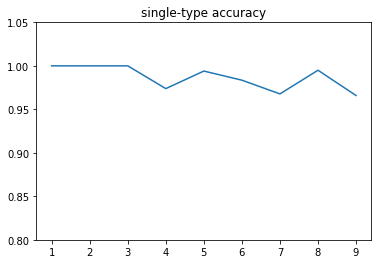

In [43]:
plt.figure()
plt.title('single-type accuracy')
plt.plot(np.arange(1, 10), acc_list[0:9])
plt.ylim([0.8, 1.05])
acc_list[0:9]

[0.959596,
 1.0,
 0.984375,
 0.9897959,
 0.95477384,
 0.97356826,
 0.93301433,
 0.98086125,
 0.9851485,
 0.96713614,
 0.955,
 0.9953052,
 0.9490741]

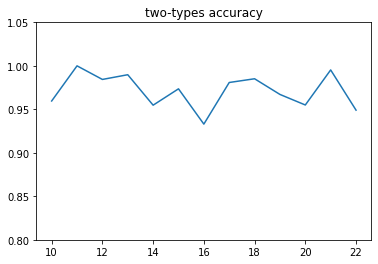

In [44]:
plt.figure()
plt.title('two-types accuracy')
plt.plot(np.arange(10, 23), acc_list[9:22])
plt.ylim([0.8, 1.05])
acc_list[9:22]

[0.9095238,
 0.9818182,
 0.97619045,
 0.9851485,
 0.94170403,
 0.92523366,
 0.93434346,
 0.95652175,
 0.98139536,
 0.9101124,
 0.8910891,
 0.9326923]

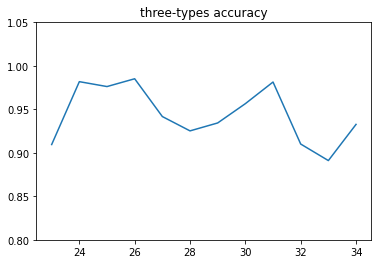

In [45]:
plt.figure()
plt.title('three-types accuracy')
plt.plot(np.arange(23, 35), acc_list[22:34])
plt.ylim([0.8, 1.05])
acc_list[22:34]

[0.857868, 0.9392265, 0.8020833, 0.90865386]

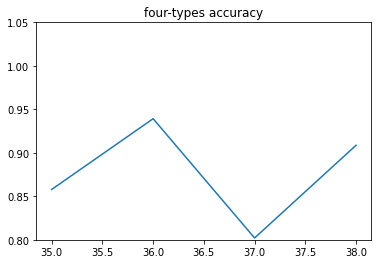

In [46]:
plt.figure()
plt.title('four-types accuracy')
plt.plot(np.arange(35, 39), acc_list[34:])
plt.ylim([0.8, 1.05])
acc_list[34:]

Generating Class Activation Maps

Shows for a particular class, where in the image the model "paid attention to" for the prediction.

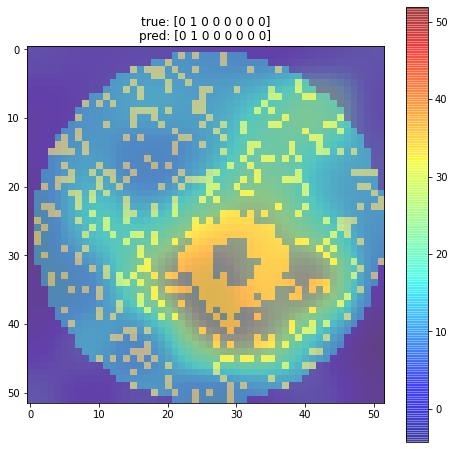

In [47]:
import scipy as sp

cam_model = tf.keras.Model(inputs=model.input, 
                           outputs=[model.get_layer('defconv_4').output, model.get_layer('FC').output])
output_layer_weights = model.get_layer('FC').get_weights()[0] # exclude the bias

idx = 24984 # 'donut' fault indices between 24000 and 24999
img_class = 1 # fault: 'donut'

img = np.expand_dims(dataset_x_cnn[idx,:,:,:], axis=0) # (1, 52, 52, 1)
features, results = cam_model.predict(img)
# "features" is the output of the last deconv layer with shape (1, 7, 7, 128)
# "results" is the output of the model, or its predictions

img_features = features[0] # (7, 7, 128)
prediction = np.where(results[0]>.5, 1, 0)

class_activation_weights = output_layer_weights[:, img_class] # (128,)
# rescaling the features map to the original image size
class_activation_features = sp.ndimage.zoom(img_features, (52/7, 52/7, 1), order=2) # (52, 52, 128)

cam_output  = np.dot(class_activation_features, class_activation_weights)

plt.figure(figsize=(8,8))
plt.title(f'true: {dataset_y[idx]}\npred: {prediction}')
plt.imshow(cam_output, cmap='jet', alpha=0.5)
plt.colorbar()
plt.imshow(tf.squeeze(img), alpha=0.5)
plt.show()
